In [1]:
%pylab inline

import pandas as pd

from pytz import timezone
from datetime import datetime
from deribit_api import RestClient
from scipy.optimize import curve_fit, brentq
from scipy.stats import norm

rcParams['axes.grid'] = True
rcParams['figure.figsize'] = (12,8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def now_in_utc():
    return datetime.now(timezone('UTC'))

def time_to_dt(dt):
    return (dt - now_in_utc()).total_seconds() / (60*60*24) / 365 

def BS_price(F, K, T, r, sigma, pc):
    d1 = (np.log(F/K) + (sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if pc == 'call':
        return np.exp(-r*T)*(norm.cdf(d1)*F - norm.cdf(d2)*K)
    else:
        return np.exp(-r*T)*(norm.cdf(-d2)*K - norm.cdf(-d1)*F)

class Future:
    def __init__(self, instrument):
        self.name = instrument['instrumentName']
        self.expiry = pd.to_datetime(instrument['expiration'])
        
    def time_to_expiry(self):
        return time_to_dt(self.expiry)
    
    def implied_carry(self, rate):
        spot = client.index()['btc']
        mark = self.get_mark()
        return np.log(mark/spot)/self.time_to_expiry() - rate
        
    def get_mark(self):
        return client.getorderbook(self.name)['mark']
    
class Option:
    def __init__(self, instrument):
        self.name = instrument['instrumentName']
        self.expiry = pd.to_datetime(instrument['expiration'])
        self.strike = instrument['strike']
        self.putcall = instrument['optionType']
        
    def time_to_expiry(self):
        return time_to_dt(self.expiry)
    
    def get_mark(self):
        return client.getorderbook(self.name)['mark'] * client.index()['btc']
    
    def forward(self, rate):
        spot = client.index()['btc']
        bc   = borrow_curve(self.time_to_expiry())
        return spot*np.exp((rate + bc)*self.time_to_expiry())
    
    def implied_vol(self, rate):
        F = self.forward(rate)
        mark  = self.get_mark()
        error = lambda sigma: BS_price(F, self.strike, self.time_to_expiry(), rate, sigma, self.putcall) - mark
        return brentq(error, 0.01, 10.0)

In [3]:
keys = open('keys.txt','r').read().split('\n')[:-1]
client = RestClient(key=keys[0],secret=keys[1])

In [4]:
instruments = client.getinstruments()

In [5]:
# Fit borrow curve to futures
btc_futures = [inst for inst in instruments if inst['kind'] == 'future' 
               and inst['baseCurrency'] == 'BTC' and inst['settlement'] != 'perpetual']
btc_futures = [Future(inst) for inst in btc_futures]

borrows = pd.Series([inst.implied_carry(0) for inst in btc_futures],
                    index=[inst.time_to_expiry() for inst in btc_futures])
borrows = borrows.sort_index()

def borrow_curve(t):
    return np.interp(0.5, borrows.index, borrows.values)

In [6]:
options = [inst for inst in instruments if inst['kind'] == 'option' and inst['baseCurrency'] == 'BTC']

In [7]:
expiries = np.unique([opt['expiration'] for opt in options])

In [8]:
vol_func = lambda NS, atm, skew, vov, kurt: atm + NS*skew + NS**2*vov + NS**3*kurt #+ (NS > 2)*cw + (NS < -2)*pw
def fit_expiry(expiry):
    #expiration = '2020-09-25'
    #expiry = expiration + ' 08:00:00 GMT'
    spot = client.index()['btc']

    this_expiry = [opt for opt in options if opt['expiration'] == expiry]
    this_expiry.sort(key=lambda opt: opt['strike'])

    OTM_call = [Option(opt) for opt in this_expiry if (opt['optionType'] == 'call' and opt['strike'] > spot)]
    OTM_put  = [Option(opt) for opt in this_expiry if (opt['optionType'] == 'put' and opt['strike'] <= spot)]
    vols_call = [opt.implied_vol(0) for opt in OTM_call]
    vols_put  = [opt.implied_vol(0) for opt in OTM_put]
    
    OTM  = OTM_put+OTM_call
    vols = vols_put+vols_call

    ATM_vol   = vols_put[-1]
    NS_strike = [np.log(OTM[idx].strike / OTM[idx].forward(0))/(vols[idx]*np.sqrt(OTM[idx].time_to_expiry())) 
                 for idx in range(len(OTM))]
    
    return NS_strike, vols, curve_fit(vol_func, NS_strike, vols)[0]

surface = {}
strikes = {}
vols = {}
for expiry in expiries:
    NS_strike, vol, params = fit_expiry(expiry)
    surface[expiry] = params
    strikes[expiry] = NS_strike
    vols[expiry] = vol

In [9]:
def surface_plot(expiry):
    plot(strikes[expiry],vols[expiry])
    plot(strikes[expiry],[vol_func(ns,*surface[expiry]) for ns in strikes[expiry]])

In [10]:
surface_frame = pd.DataFrame(surface).T
#surface_frame.index = pd.to_datetime(surface_frame.index)
surface_frame.columns = ['atm','skew','vov','kurt']

In [11]:
def norm_skew(expiry):
    c25d = norm.ppf(0.75) - surface[expiry][0]/2*np.sqrt(time_to_dt(pd.to_datetime(expiry)))
    c50d = norm.ppf(0.50) - surface[expiry][0]/2*np.sqrt(time_to_dt(pd.to_datetime(expiry)))
    return (vol_func(-c25d, *surface[expiry]) - vol_func(c25d, *surface[expiry])) / (2*vol_func(c50d, *surface[expiry]))

def norm_vov(expiry):
    c5d = norm.ppf(0.95) - surface[expiry][0]/2*np.sqrt(time_to_dt(pd.to_datetime(expiry)))
    c50d = norm.ppf(0.50) - surface[expiry][0]/2*np.sqrt(time_to_dt(pd.to_datetime(expiry)))
    return (vol_func(-c5d, *surface[expiry]) + vol_func(c5d, *surface[expiry])) / (2*vol_func(c50d, *surface[expiry]))

In [12]:
surface_frame['norm skew'] = [norm_skew(expiry) for expiry in surface_frame.index]
surface_frame['norm vov'] = [norm_vov(expiry) for expiry in surface_frame.index]

In [13]:
surface_frame

,atm,skew,vov,kurt,norm skew,norm vov
2020-08-09 08:00:00 GMT,0.545428,0.037400,0.008518,-0.000133,-0.045542,1.042450
2020-08-10 08:00:00 GMT,0.461144,0.027060,0.070712,0.002831,-0.040520,1.408699
2020-08-14 08:00:00 GMT,0.488667,-0.033875,0.095794,0.001503,0.043761,1.507878
2020-08-21 08:00:00 GMT,0.477738,0.046189,0.111508,-0.025622,-0.047692,1.604165
2020-08-28 08:00:00 GMT,0.531407,0.035893,0.117417,-0.024236,-0.031004,1.559187
2020-09-25 08:00:00 GMT,0.639129,-0.071733,0.089312,0.011697,0.058700,1.307652
2020-12-25 08:00:00 GMT,0.679123,0.043369,0.097779,-0.019193,-0.027053,1.305655
2021-03-26 08:00:00 GMT,0.678940,0.038996,0.067214,0.000638,-0.023539,1.197303


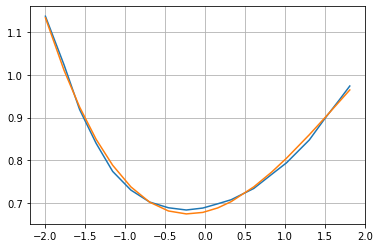

In [14]:
surface_plot('2020-12-25 08:00:00 GMT')